In [10]:
import numpy as np
import pandas as pd
import torch
from utils.ae_script import (prepare_data, 
                             create_dataset, 
                             training_loop, 
                             generate_patient_embeddings, 
                             plot_umap_by_targets, 
                             downstream_performance)

from utils.autoencoder_model import (MultimodalCrossAttentionAutoencoder,
                                     Autoencoder)

# ---------------------------------------------
# 1) LOAD & PREPROCESS DATA
# ---------------------------------------------

threshold = 10  # Set the threshold for filtering mutations
df = pd.read_csv(f"./data/msk_2024_fe_{threshold}.csv")

# locate the columns index for OS_MONTHS
os_months_index = df.columns.get_loc("OS_MONTHS")

gene_mutations = df.iloc[:, :os_months_index]  # Exclude the first column (ID) and OS_MONTHS
data_labels = df.iloc[:, os_months_index:]  # Include only the OS_MONTHS column as labels

In [11]:
GMP, CD_BINARY, CD_NUMERIC, patient_ids = prepare_data(gene_mutations, data_labels)

In [12]:
num_positives = np.sum(GMP, axis=0)  # Count the number of positive mutations for each gene
num_negatives = GMP.shape[0] - num_positives  # Count the number of negative mutations for each gene
pos_weight = num_negatives / (num_positives + 1e-6)  # Avoid division by zero
pos_weight = torch.tensor(pos_weight, dtype=torch.float32)

In [13]:
# parameters
batch_size = 4096
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
train_loader, val_loader = create_dataset(
    GMP, CD_BINARY, CD_NUMERIC, 
    batch_size=batch_size, 
    train_split=0.85
)

In [15]:
ae_type = "mcaae" # Choose between "msaae" "mcaae" or "gmp"
training_method = 'normal'  # Loss function for autoencoder (can be 'normal', 'masked', or 'denoising')
backbone = "attn_v2" # 'mlp', 'residual', 'attn', 'attn_v2', 'self_attn'

latent_dim = 256
hidden_dim = 256
num_layers = 2  # Number of layers for the backbone (if applicable)
dropout = 0.3  # Dropout rate for the backbone (if applicable)
num_heads = 4  # Number of attention heads for the backbone (if applicable)

ae_save_path = None
patient_rep_save_path = None
ae_losses_plot_path = None
fig_save_path = None
test_results = None
model_save_path = None

if ae_type == "msaae":
    input_dim = GMP.shape[1] + CD_BINARY.shape[1] + CD_NUMERIC.shape[1]
elif ae_type == "gmp":
    input_dim = GMP.shape[1]

if ae_type == "mcaae":
    model = MultimodalCrossAttentionAutoencoder(
        input_dim_gmp=GMP.shape[1], 
        input_dim_cd=CD_BINARY.shape[1] + CD_NUMERIC.shape[1],
        hidden_dim=hidden_dim, 
        latent_dim=latent_dim, 
        num_heads=num_heads,
        dropout=dropout,
        num_layers=num_layers,
    ).to(device)
    
elif ae_type == "msaae" or ae_type == "gmp":
    model = Autoencoder(
        input_dim=input_dim, 
        latent_dim=latent_dim, 
        backbone=backbone,
        hidden_dim=hidden_dim,
        dropout=dropout,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)
else:
    raise ValueError("Invalid model type. Choose 'multimodal' or 'autoencoder'.")

Training on device: cuda
Model Type: MultimodalCrossAttentionAutoencoder
AE Type: mcaae, Training Method: normal, L2 Lambda: 0.0001, Mask Ratio: 0.3, Noise Level: 0.1, Noise Rate: 0.1
Best model updated at epoch 1 with val loss: 3.9288
Best model updated at epoch 2 with val loss: 3.1715
Best model updated at epoch 3 with val loss: 2.9800
Best model updated at epoch 4 with val loss: 2.8570
Best model updated at epoch 5 with val loss: 2.7578
Best model updated at epoch 6 with val loss: 2.6073
Best model updated at epoch 7 with val loss: 2.4629
Best model updated at epoch 8 with val loss: 2.3397
Best model updated at epoch 9 with val loss: 2.2040
Epoch 10/70, Train Loss: 2.2094, Val Loss: 2.1009
Best model updated at epoch 10 with val loss: 2.1009
Best model updated at epoch 11 with val loss: 1.9902
Best model updated at epoch 12 with val loss: 1.9046
Best model updated at epoch 13 with val loss: 1.8255
Best model updated at epoch 14 with val loss: 1.7452
Best model updated at epoch 15 wi

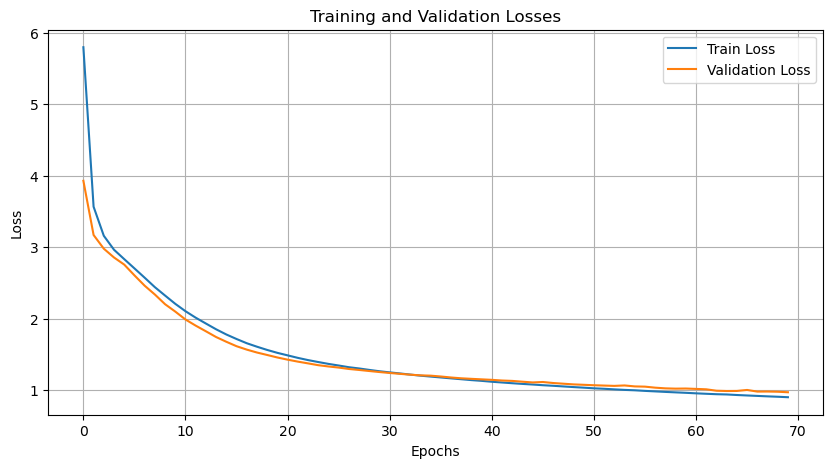

In [16]:
num_epochs = 70
learning_rate = 0.001
alpha = 0.4
l2_lambda = 1e-4
mask_ratio = 0.3  # Ratio of input features to mask (for masked autoencoder)
noise_std = 0.1  # Standard deviation of Gaussian noise (for denoising autoencoder)
noise_rate = 0.1 # Rate of noise (for denoising autoencoder)
pos_weight = pos_weight.to(device)  # Move pos_weight to the same device as the model

train_losses, val_losses, best_model = training_loop(
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        num_epochs = num_epochs,
        learning_rate = learning_rate,
        pos_weight= pos_weight,
        device= device,
        training_method = training_method,
        ae_type = ae_type,
        l2_lambda = l2_lambda,
        mask_ratio = mask_ratio,
        noise_std = noise_std,
        noise_rate = noise_rate,
        ae_save_path = ae_save_path,
        ae_losses_plot_path = ae_losses_plot_path
)

latent_rep, latent_df = generate_patient_embeddings(
    model = model,
    gmp = GMP,
    cd_binary = CD_BINARY,
    cd_numeric = CD_NUMERIC,
    best_model = best_model,
    ae_type = ae_type,
    device = device,
    latent_dim = latent_dim,
    patient_ids = patient_ids,
    save_path = patient_rep_save_path
)

Input dimension for downstream task: 256
Training on 15598 samples, validating on 3343 samples, testing on 3343 samples.
Using model: MLP with input dimension: 256
Starting training for 100 epochs...
New best model found at epoch 1 with validation loss: 7.4757 and C-Index: 0.6318
New best model found at epoch 2 with validation loss: 7.4459 and C-Index: 0.6795
New best model found at epoch 3 with validation loss: 7.4195 and C-Index: 0.6971
New best model found at epoch 4 with validation loss: 7.3967 and C-Index: 0.7055
New best model found at epoch 5 with validation loss: 7.3774 and C-Index: 0.7099
New best model found at epoch 6 with validation loss: 7.3608 and C-Index: 0.7130
New best model found at epoch 7 with validation loss: 7.3462 and C-Index: 0.7158
New best model found at epoch 8 with validation loss: 7.3328 and C-Index: 0.7180
New best model found at epoch 9 with validation loss: 7.3199 and C-Index: 0.7196
Epoch 10/100, Train Loss: 8.7950, Val Loss: 7.3072, C-Index: 0.7205
New

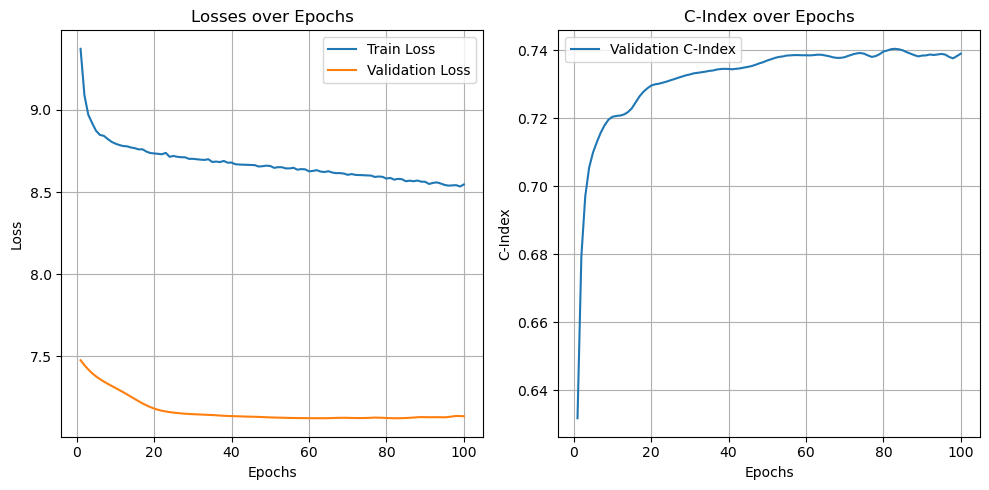

Test Loss: 7.1670, Test c-index: 0.7427


In [17]:
y_os = data_labels['OS_MONTHS']
y_status = data_labels['OS_STATUS']
ds_batch_size = 3000
whole_dataset = True
input_dim = latent_df.shape[1]
print(f"Input dimension for downstream task: {input_dim}")
ds_model = 'MLP'
ds_epoch = 100
ds_lr = 0.001
ds_l2_reg = 0.0001

train_losses, val_losses, val_c_indices, c_index_whole = downstream_performance(latent_df,
                                                                                    y_os, 
                                                                                    y_status,
                                                                                    device,
                                                                                    ds_batch_size,
                                                                                    whole_dataset,
                                                                                    ds_model,
                                                                                    ds_epoch,
                                                                                    input_dim,
                                                                                    ds_lr,
                                                                                    ds_l2_reg,
                                                                                    fig_save_path,
                                                                                    test_results,
                                                                                    model_save_path)

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


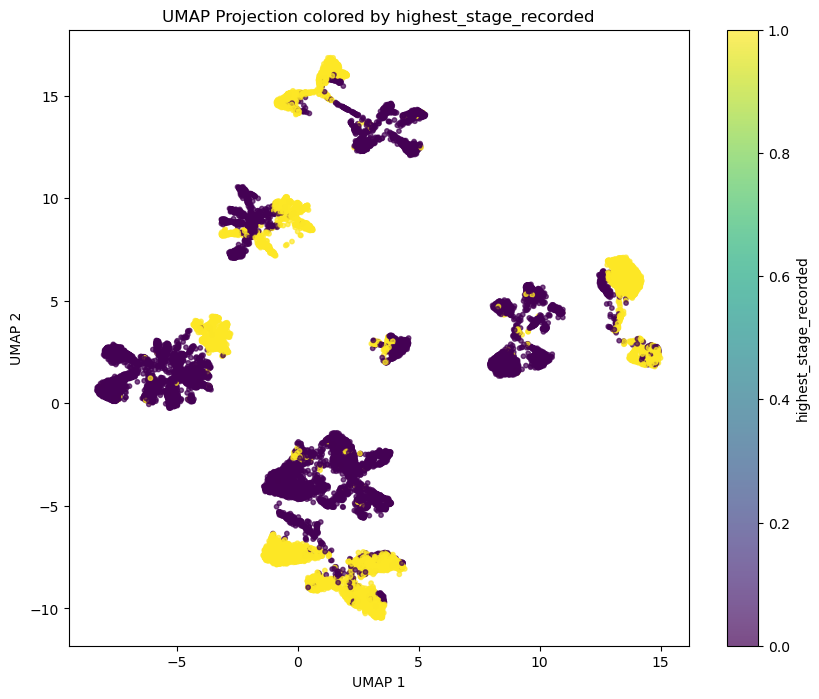

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


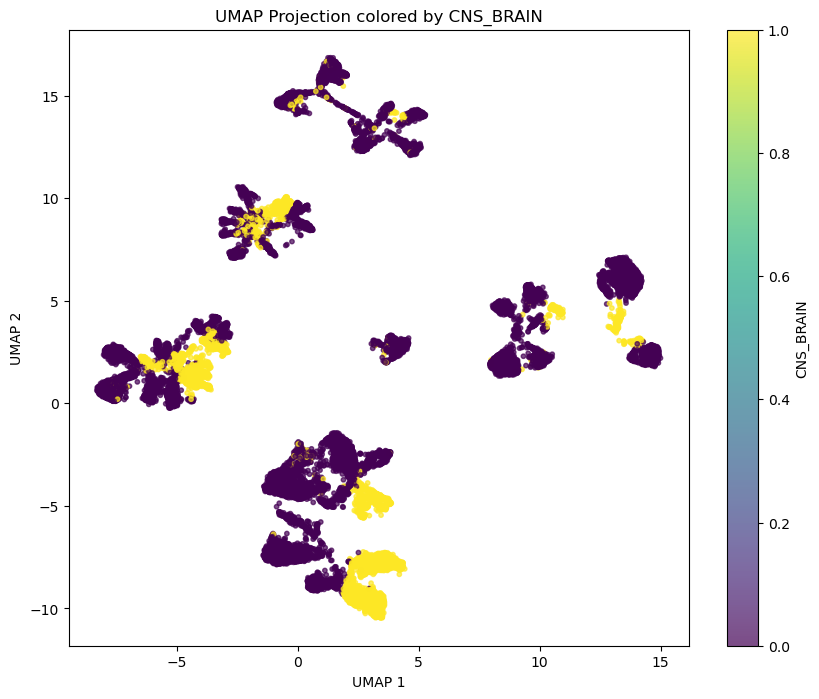

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


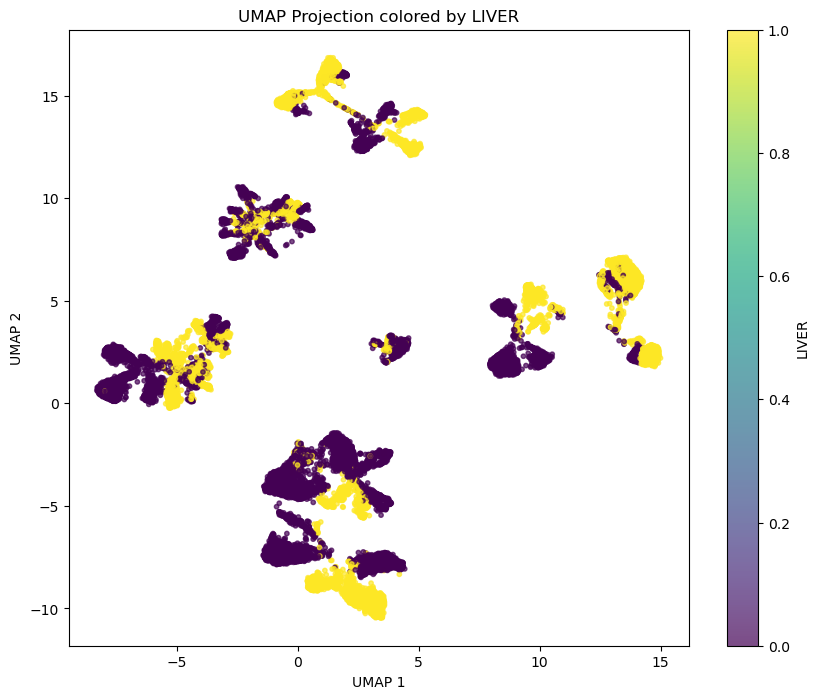

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


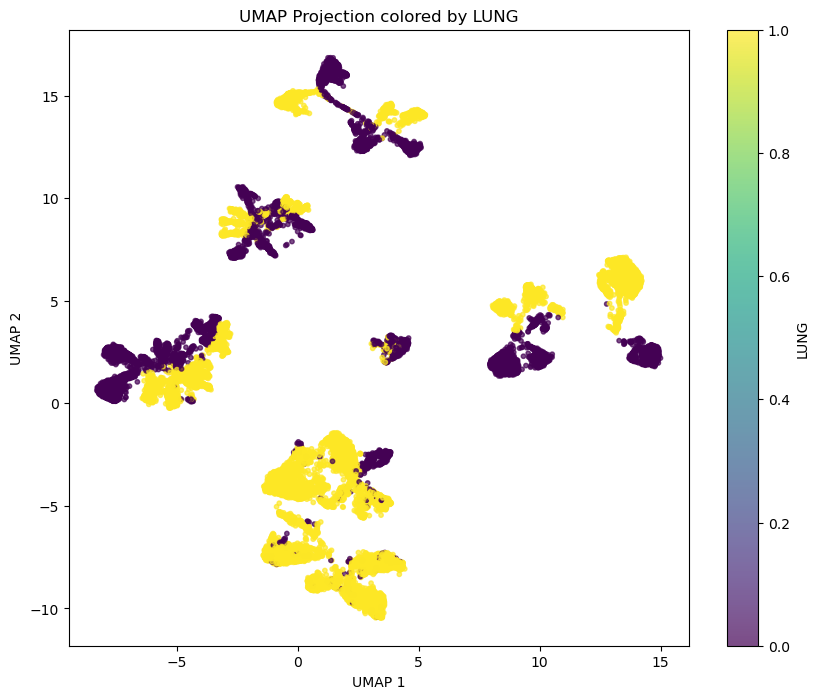

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


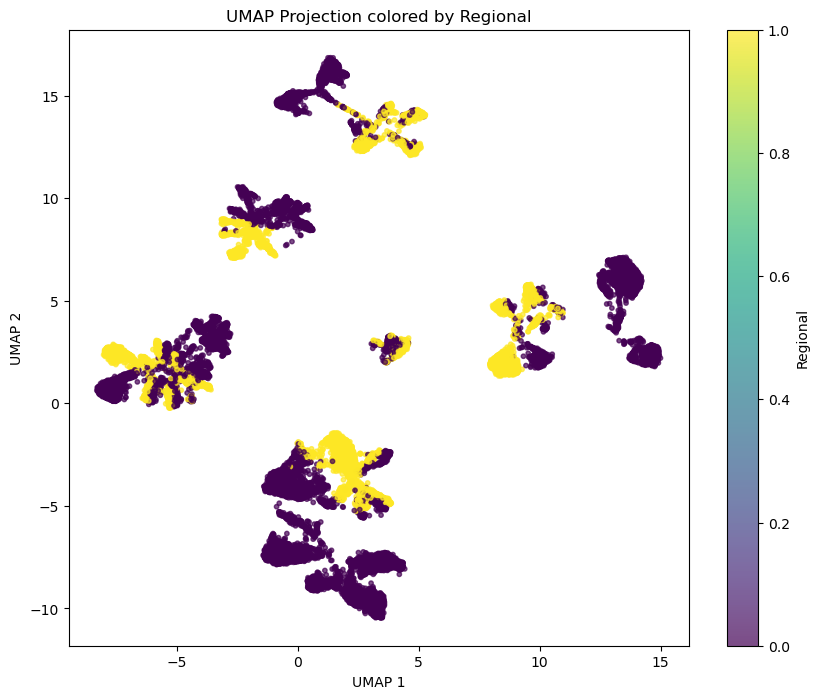

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


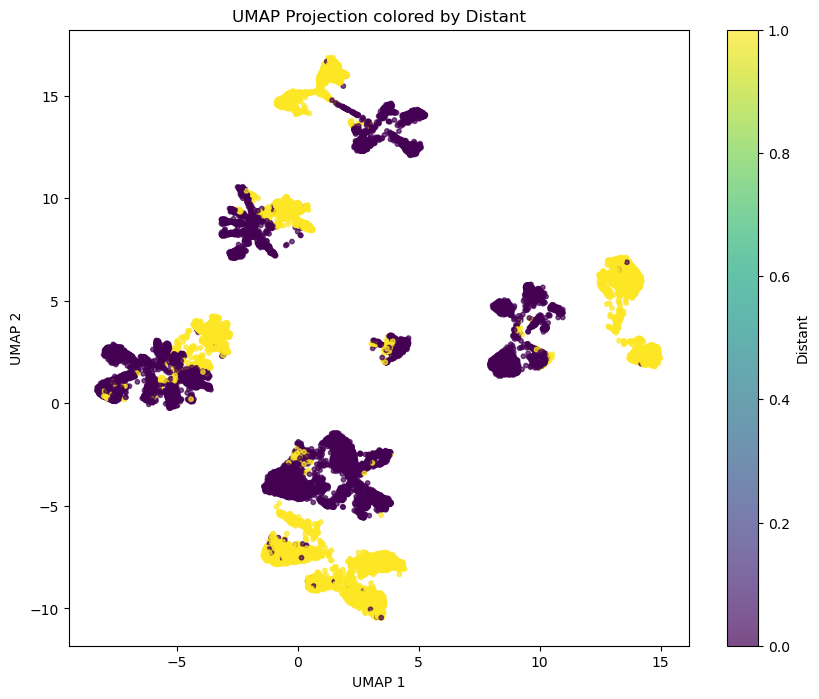

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


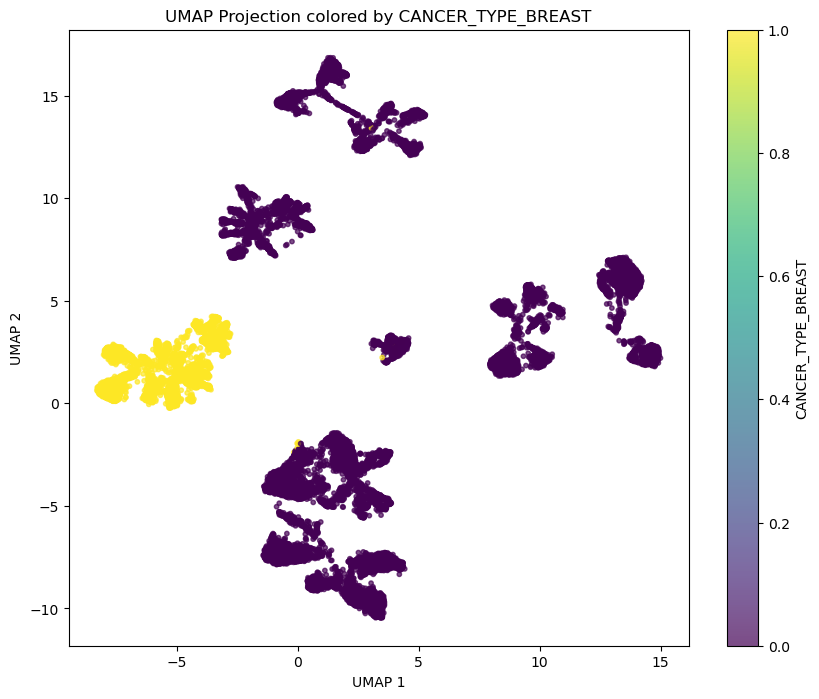

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


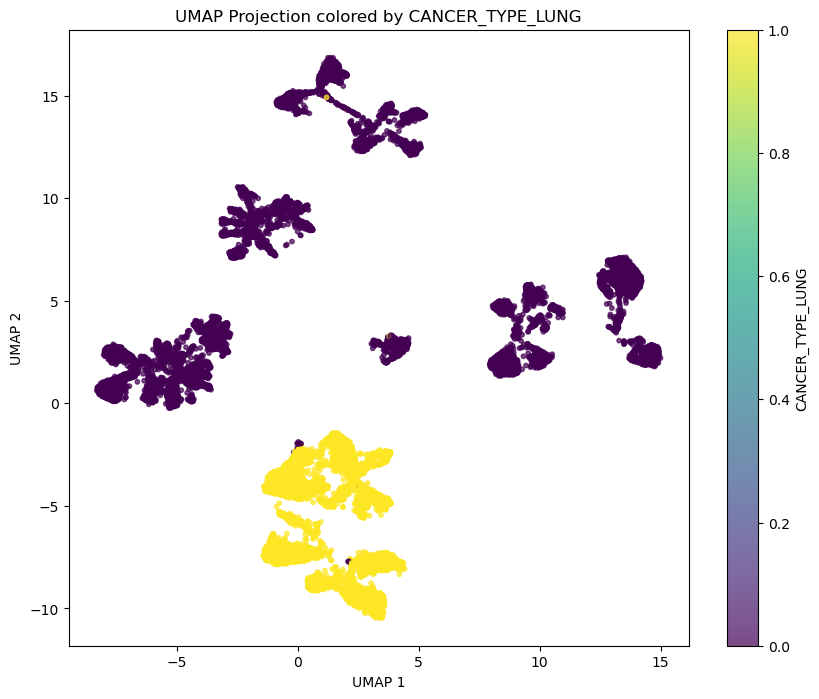

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


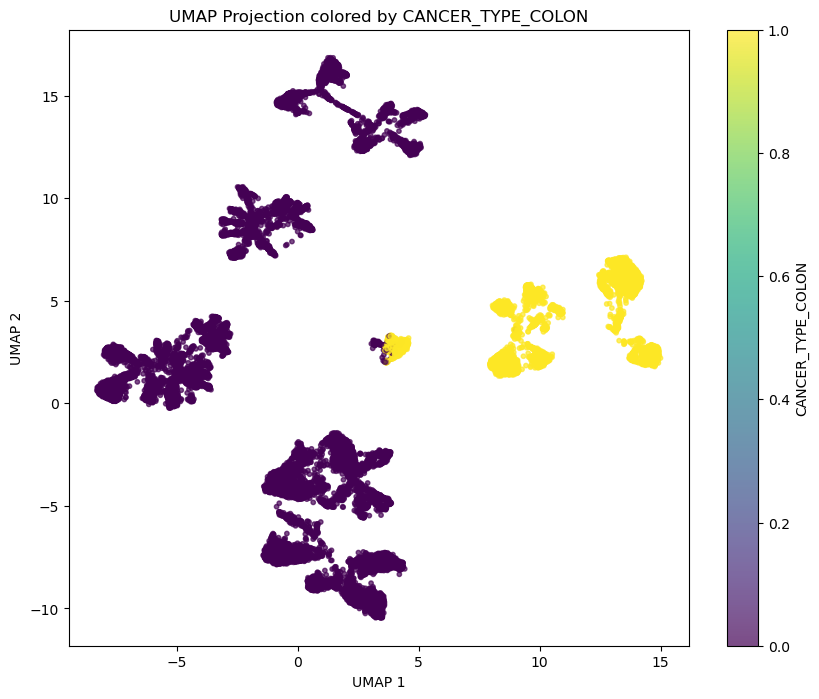

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


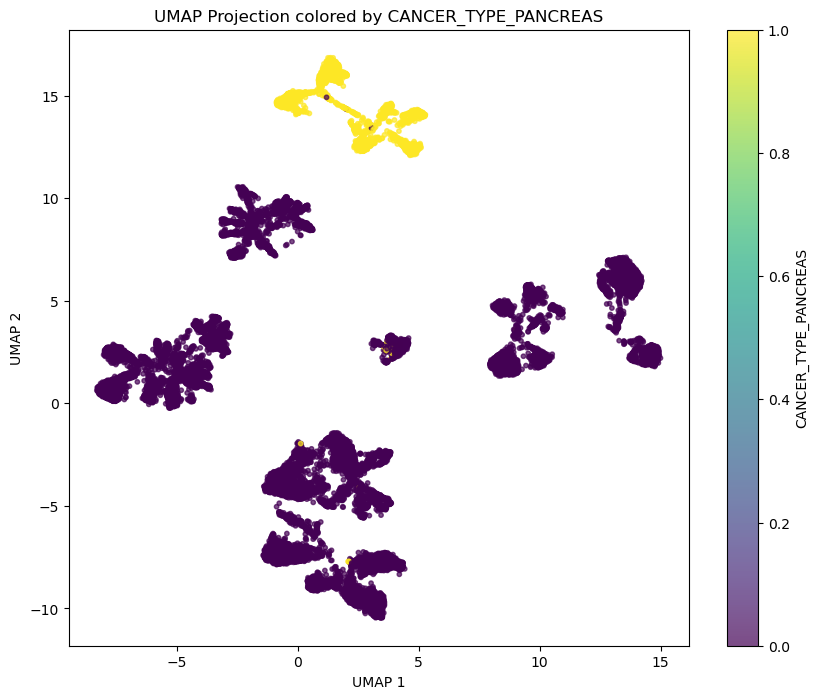

/home/lyce/miniconda3/envs/dlg/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


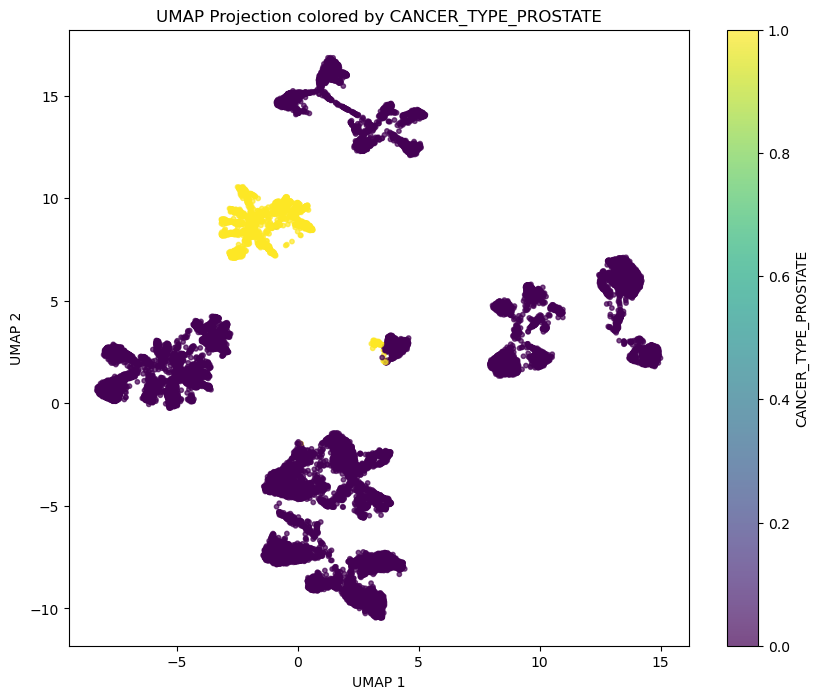

In [18]:
targets = ['highest_stage_recorded','CNS_BRAIN','LIVER','LUNG','Regional','Distant','CANCER_TYPE_BREAST','CANCER_TYPE_LUNG','CANCER_TYPE_COLON','CANCER_TYPE_PANCREAS','CANCER_TYPE_PROSTATE']

# Get highest stage recorded; convert to float32 for PyTorch
y = df[targets].values.astype(np.float32)

plot_umap_by_targets(
    latent_rep,
    y,
    targets,
    save_path_prefix=None
)